In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = '100'
from sklearn.metrics import auc

import numpy as np
import pandas as pd
from plotting import * 

import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
df_ele = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v11/run_01/validation_data/validation_dataset_v10_ele.csv", sep=";")
df_gamma = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v11/run_01/validation_data/validation_dataset_v10_gamma.csv", sep=";")
df_nomatch = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v11/run_01/validation_data/validation_dataset_v10_nomatch.csv", sep=";")

In [4]:
df_tot = pd.concat([df_nomatch, df_ele, df_gamma], sort=False)
df_tot_match = pd.concat([df_ele, df_gamma], sort=False)

In [5]:
# Add variables
for df in [df_ele, df_gamma, df_nomatch]:
    df['iz'] = df['seed_iz']
    df['ieta'] = df['seed_ieta']
    df['iphi'] = df['seed_iphi']
    df['eta'] = df['seed_eta']
    df['phi'] = df['seed_phi']
    df['en'] = df['en_seed']
    df['et'] = df['et_seed']

# N clusters

W0609 17:46:47.752647 140036922799936 font_manager.py:1357] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


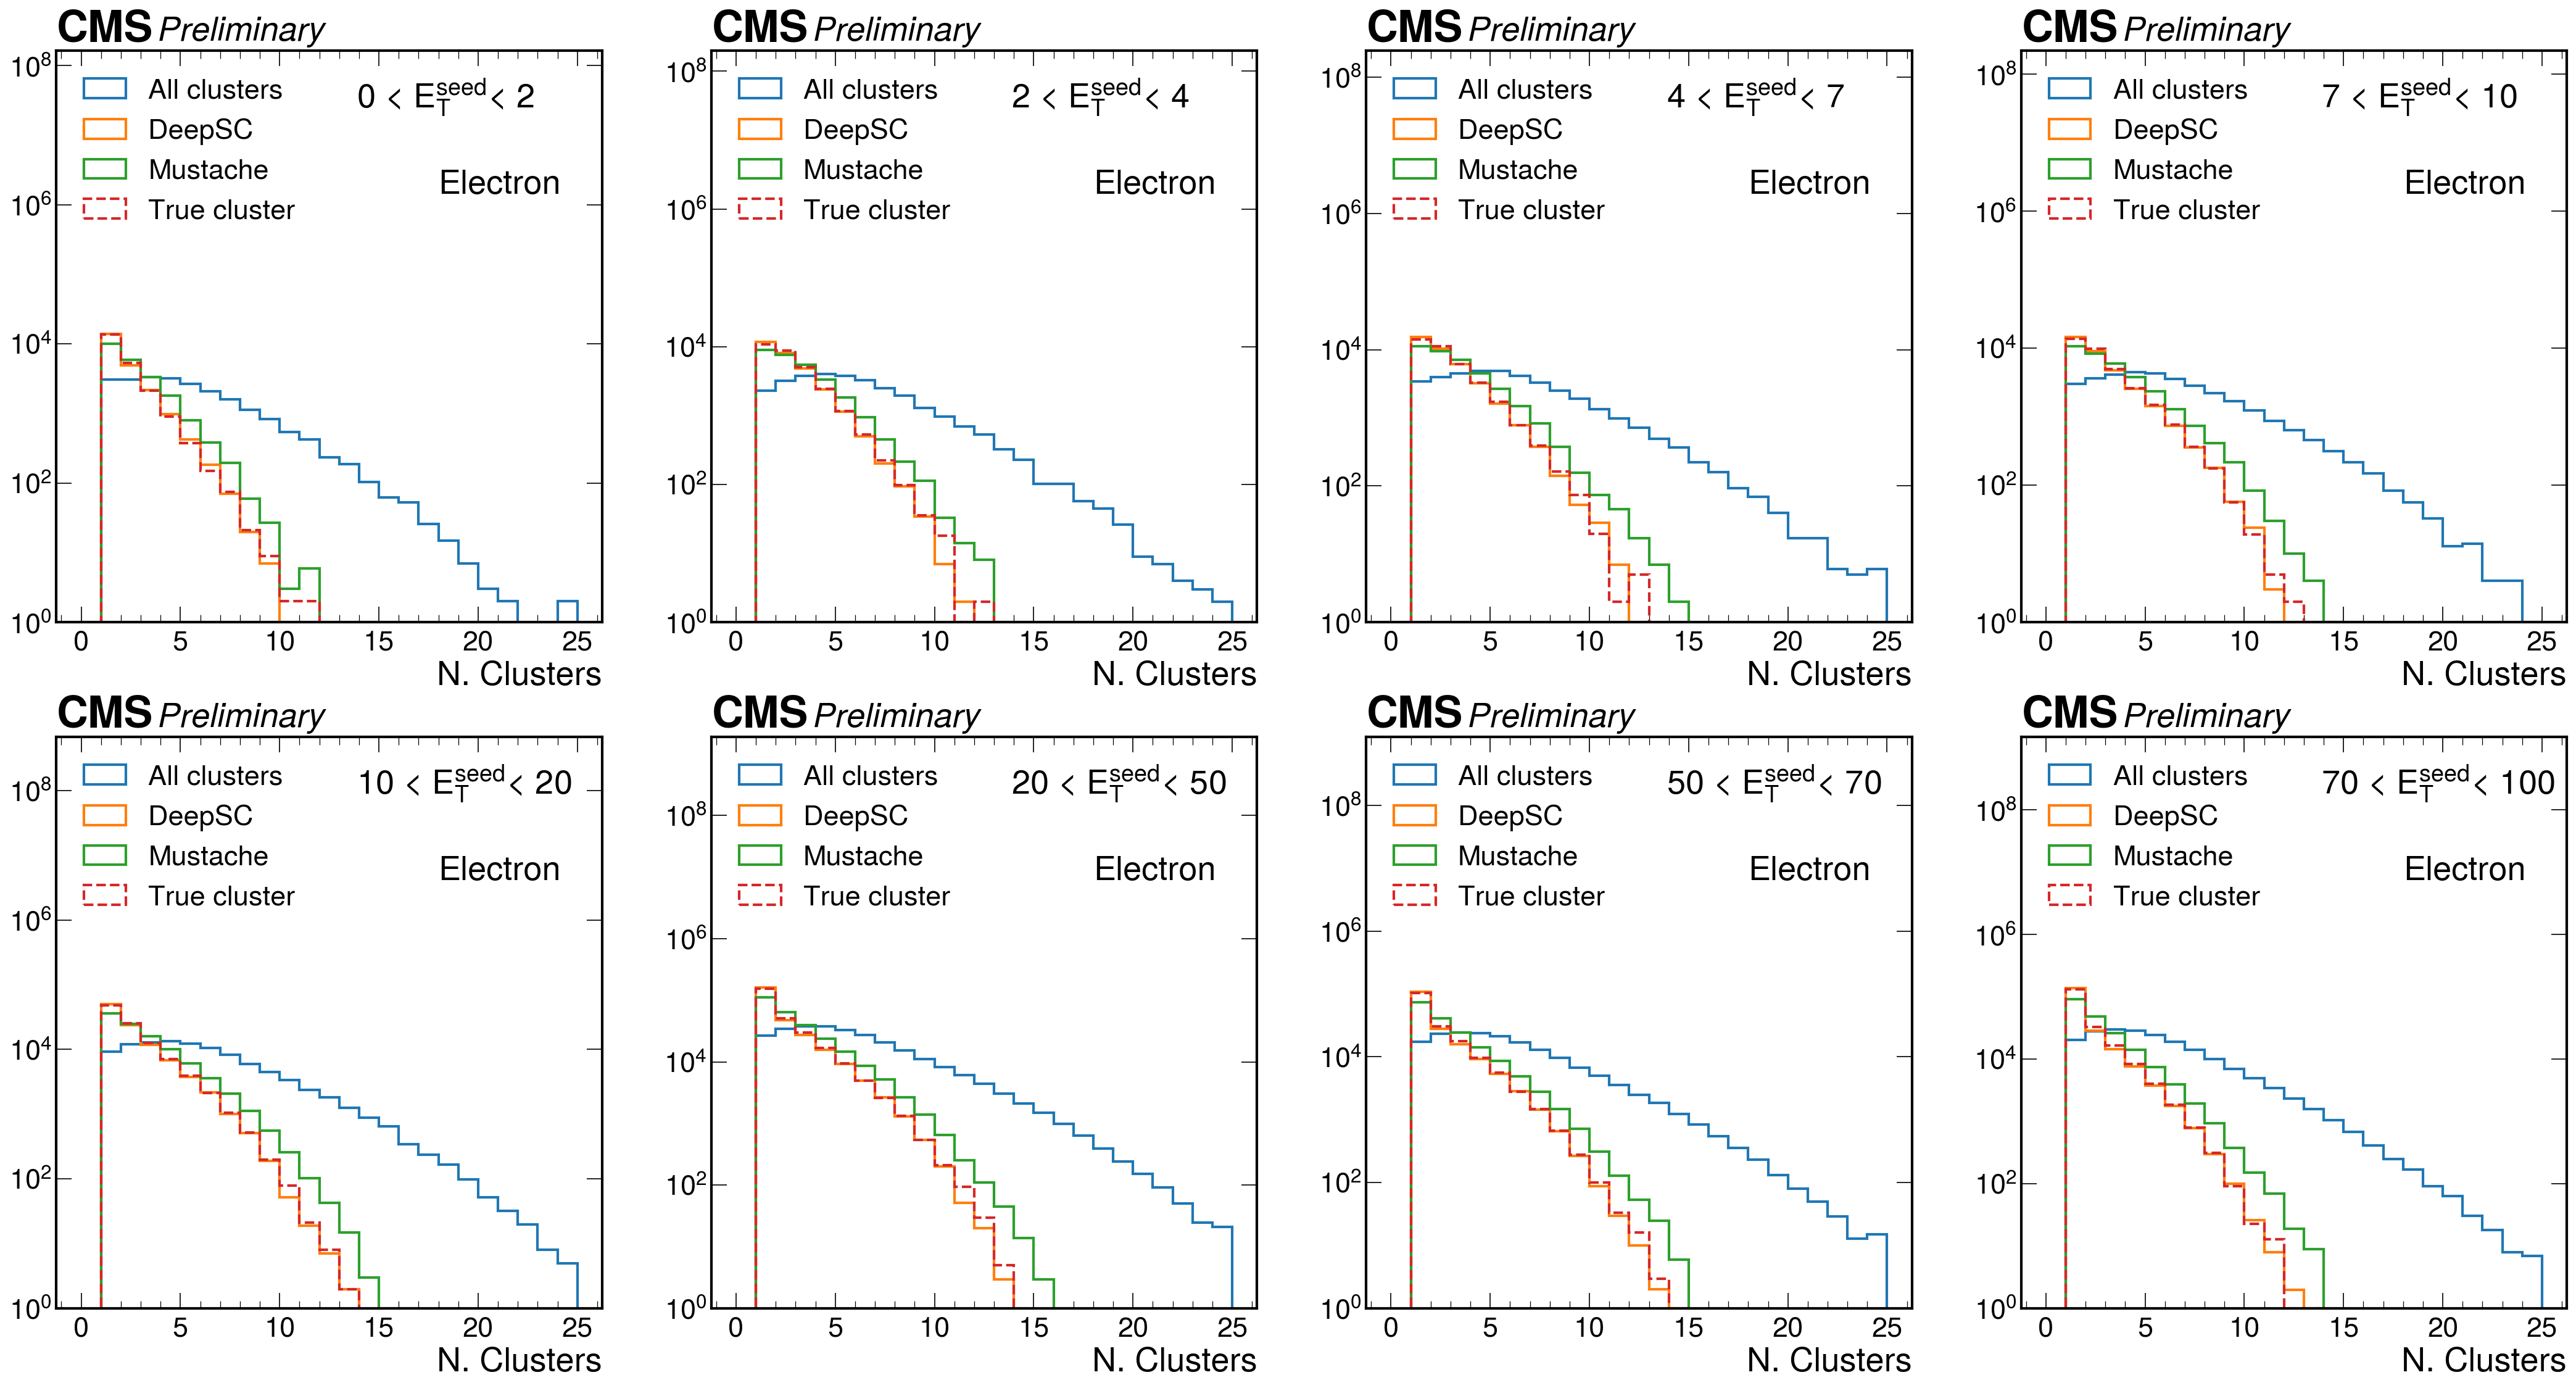

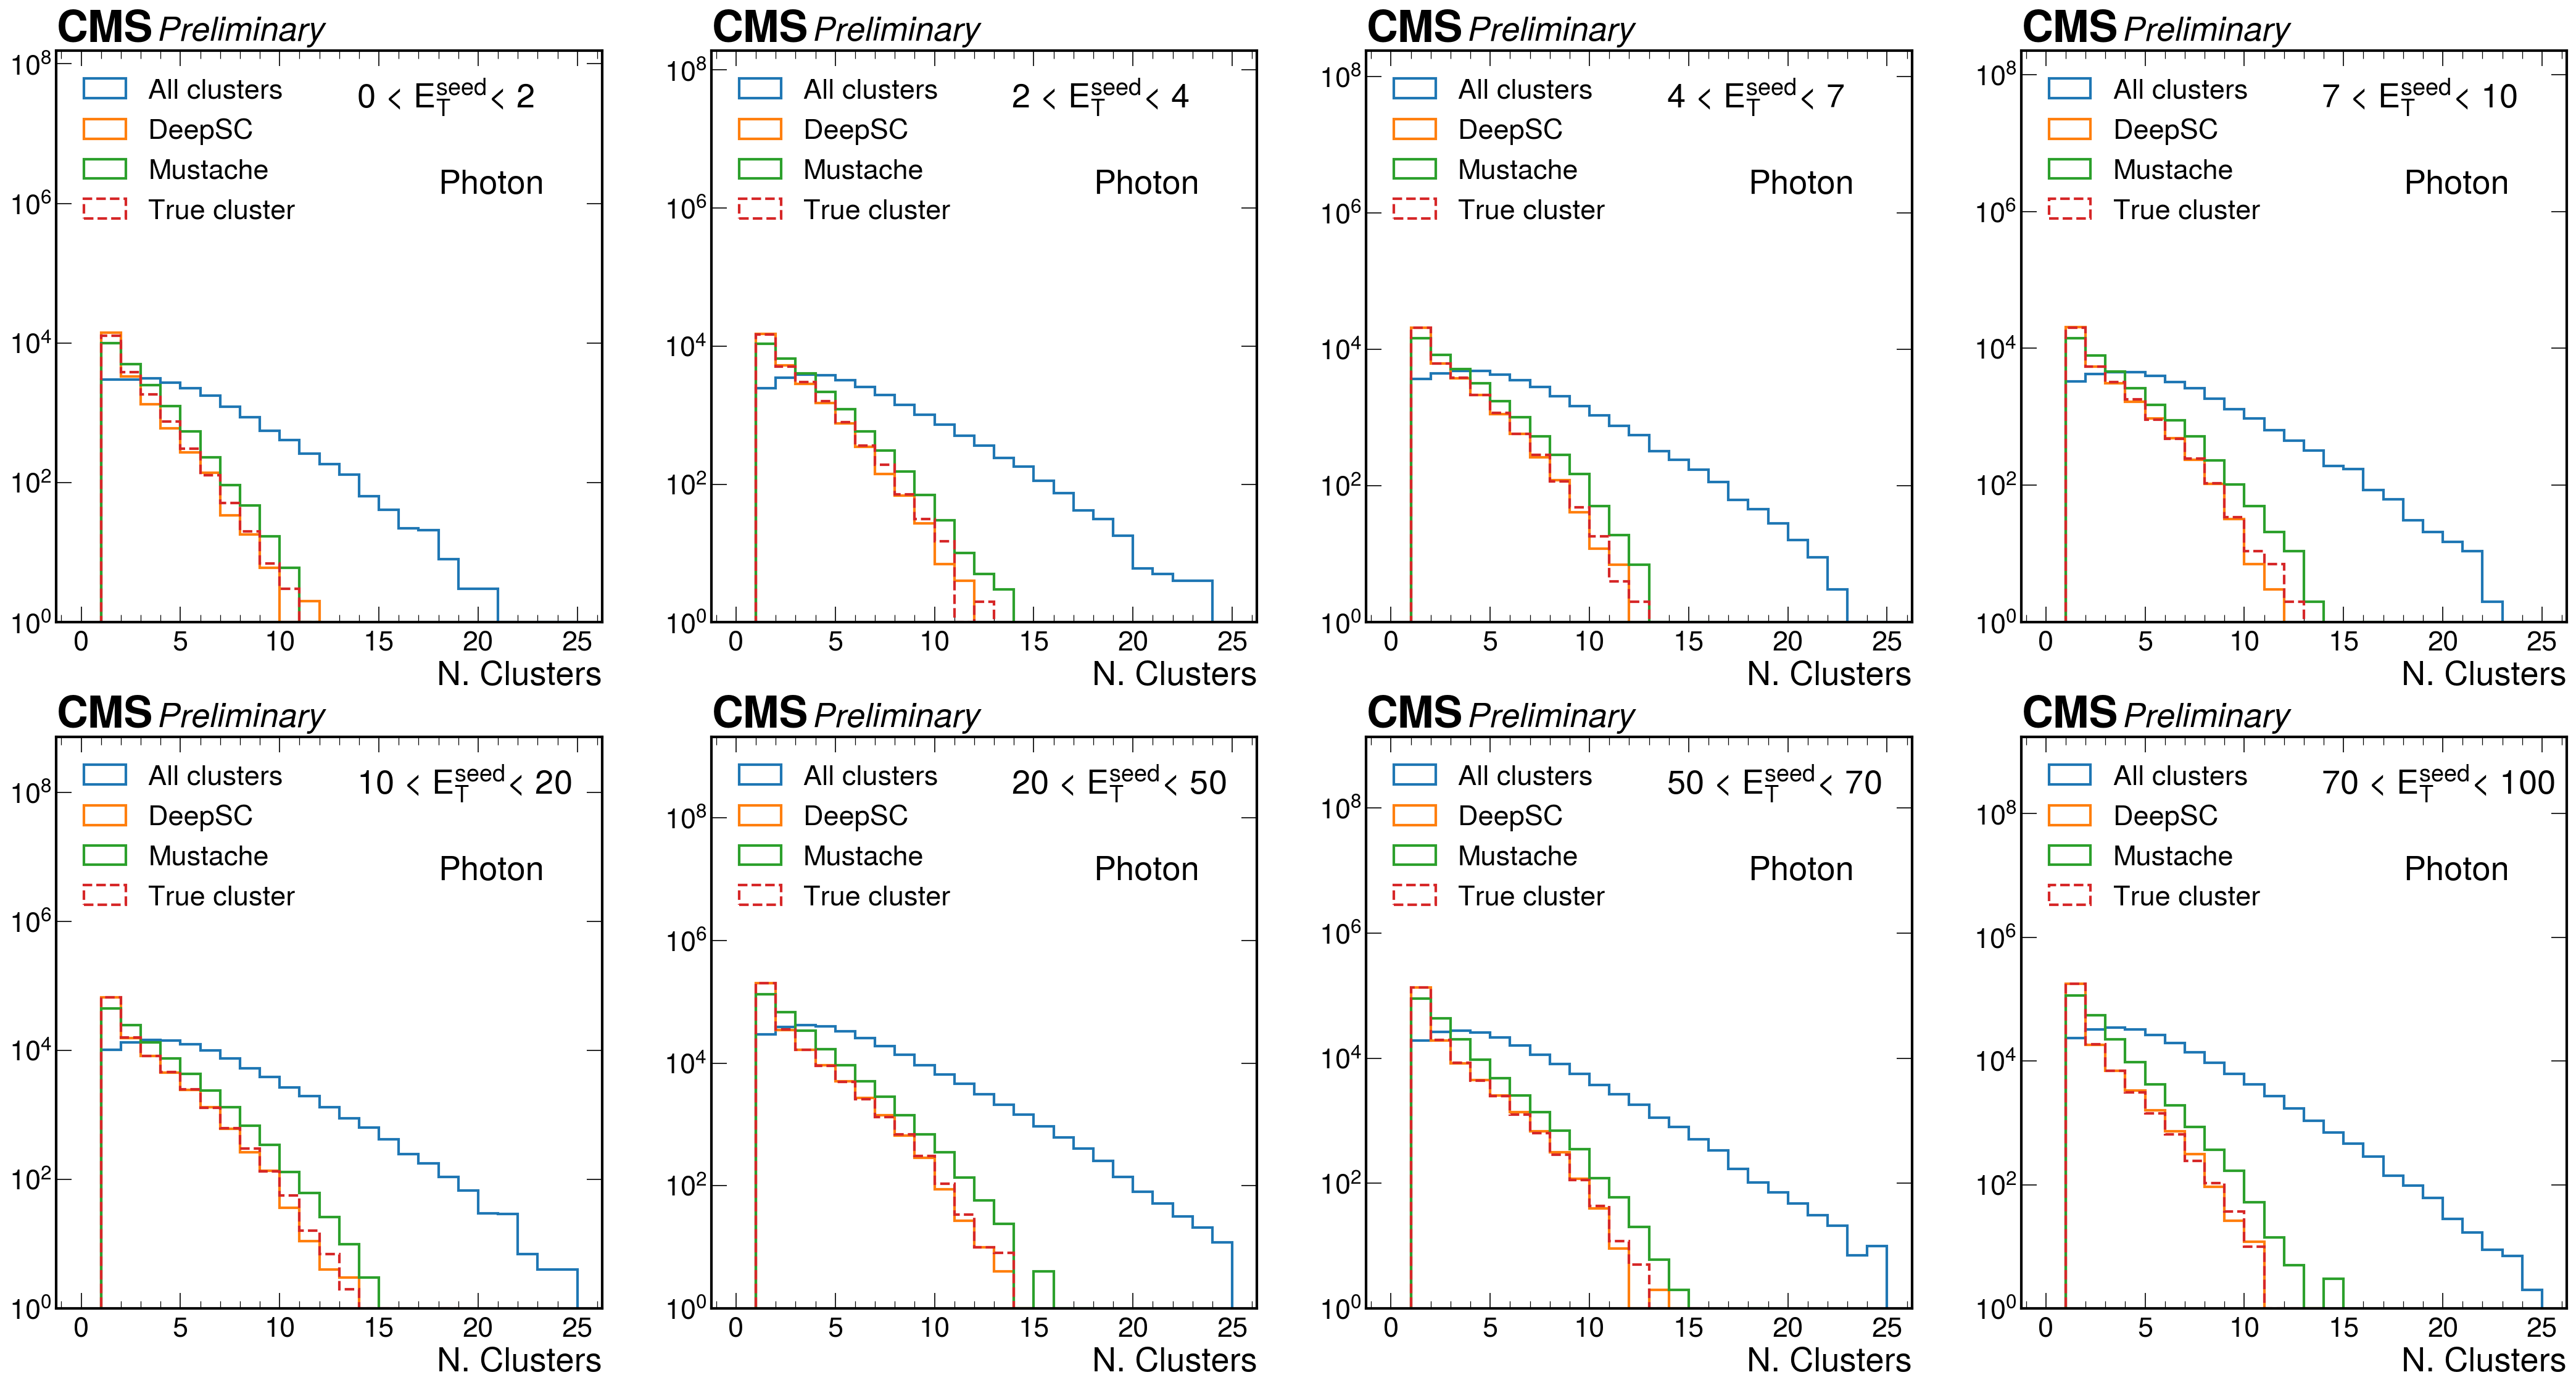

In [7]:
for df, flavour in zip([df_ele,df_gamma],["Electron","Photon"]):

    fig, ax = plt.subplots(2,4, figsize=(35,18),dpi=150)

    xrange = (0,25)
    bins= 25

    ets = [ [(0,2),(2,4),(4,7),(7,10)],[(10,20),(20,50),(50,70),(70,100)]]

    for j,etss in enumerate(ets): 
        for i, (e1,e2) in enumerate(etss): 
            dfx = df[(df.et>=e1) & (df.et<e2)]

            A = ax[j,i].hist(dfx.ncls,bins=bins, range=xrange, histtype='step', linewidth=2, label='All clusters')
            ax[j,i].hist(dfx.ncls_sel,bins=bins, range=xrange, histtype='step', linewidth=2, label='DeepSC')
            ax[j,i].hist(dfx.ncls_sel_must,bins=bins, range=xrange, histtype='step', linewidth=2, label='Mustache')
            ax[j,i].hist(dfx.ncls_true,bins=bins, range=xrange, histtype='step', linewidth=2, linestyle='dashed', label='True cluster')
            maxY = np.max(A[0])
            ax[j,i].legend(loc="upper left")
            ax[j,i].set_yscale('log')
            ax[j,i].set_ylim(1, 5e4 * maxY)
            ax[j,i].set_xlabel("N. Clusters")
            ax[j,i].text(0.55,0.9,  str(e1) + ' < $E_T^{seed}$< ' + str(e2), transform = ax[j,i].transAxes)  
            ax[j,i].text(0.7, 0.75, flavour, transform=ax[j,i].transAxes)

            hep.cms.text("Preliminary ",loc=0, ax=ax[j,i])


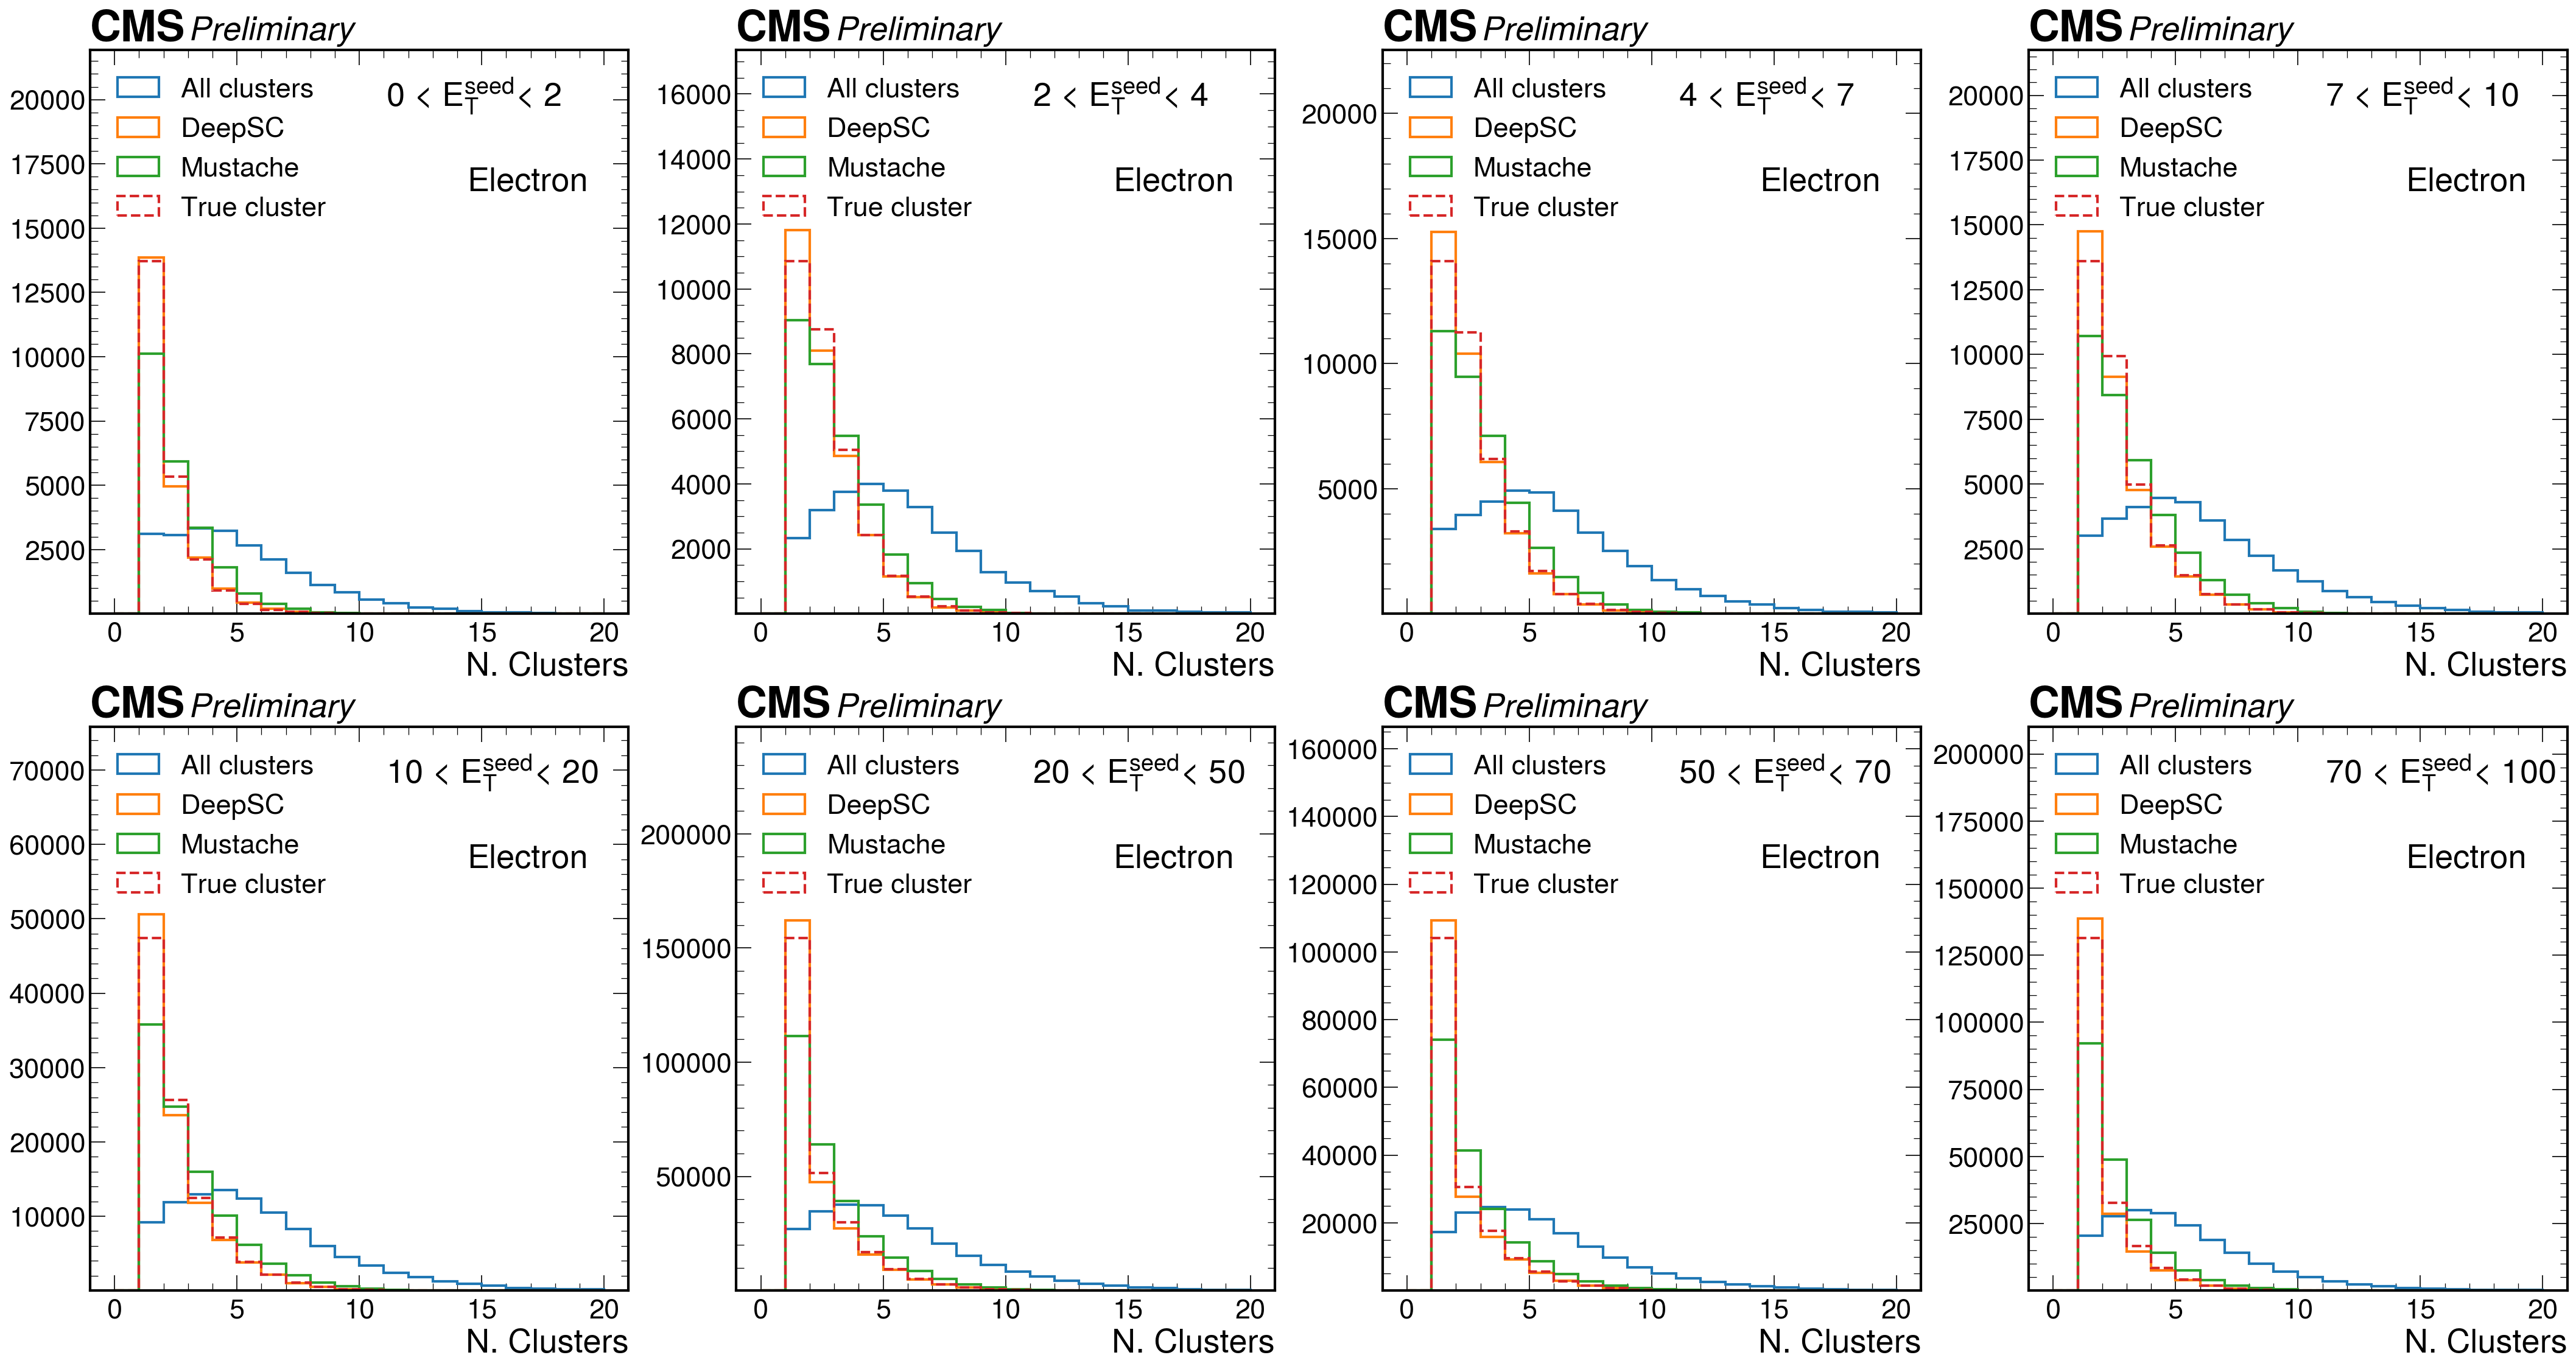

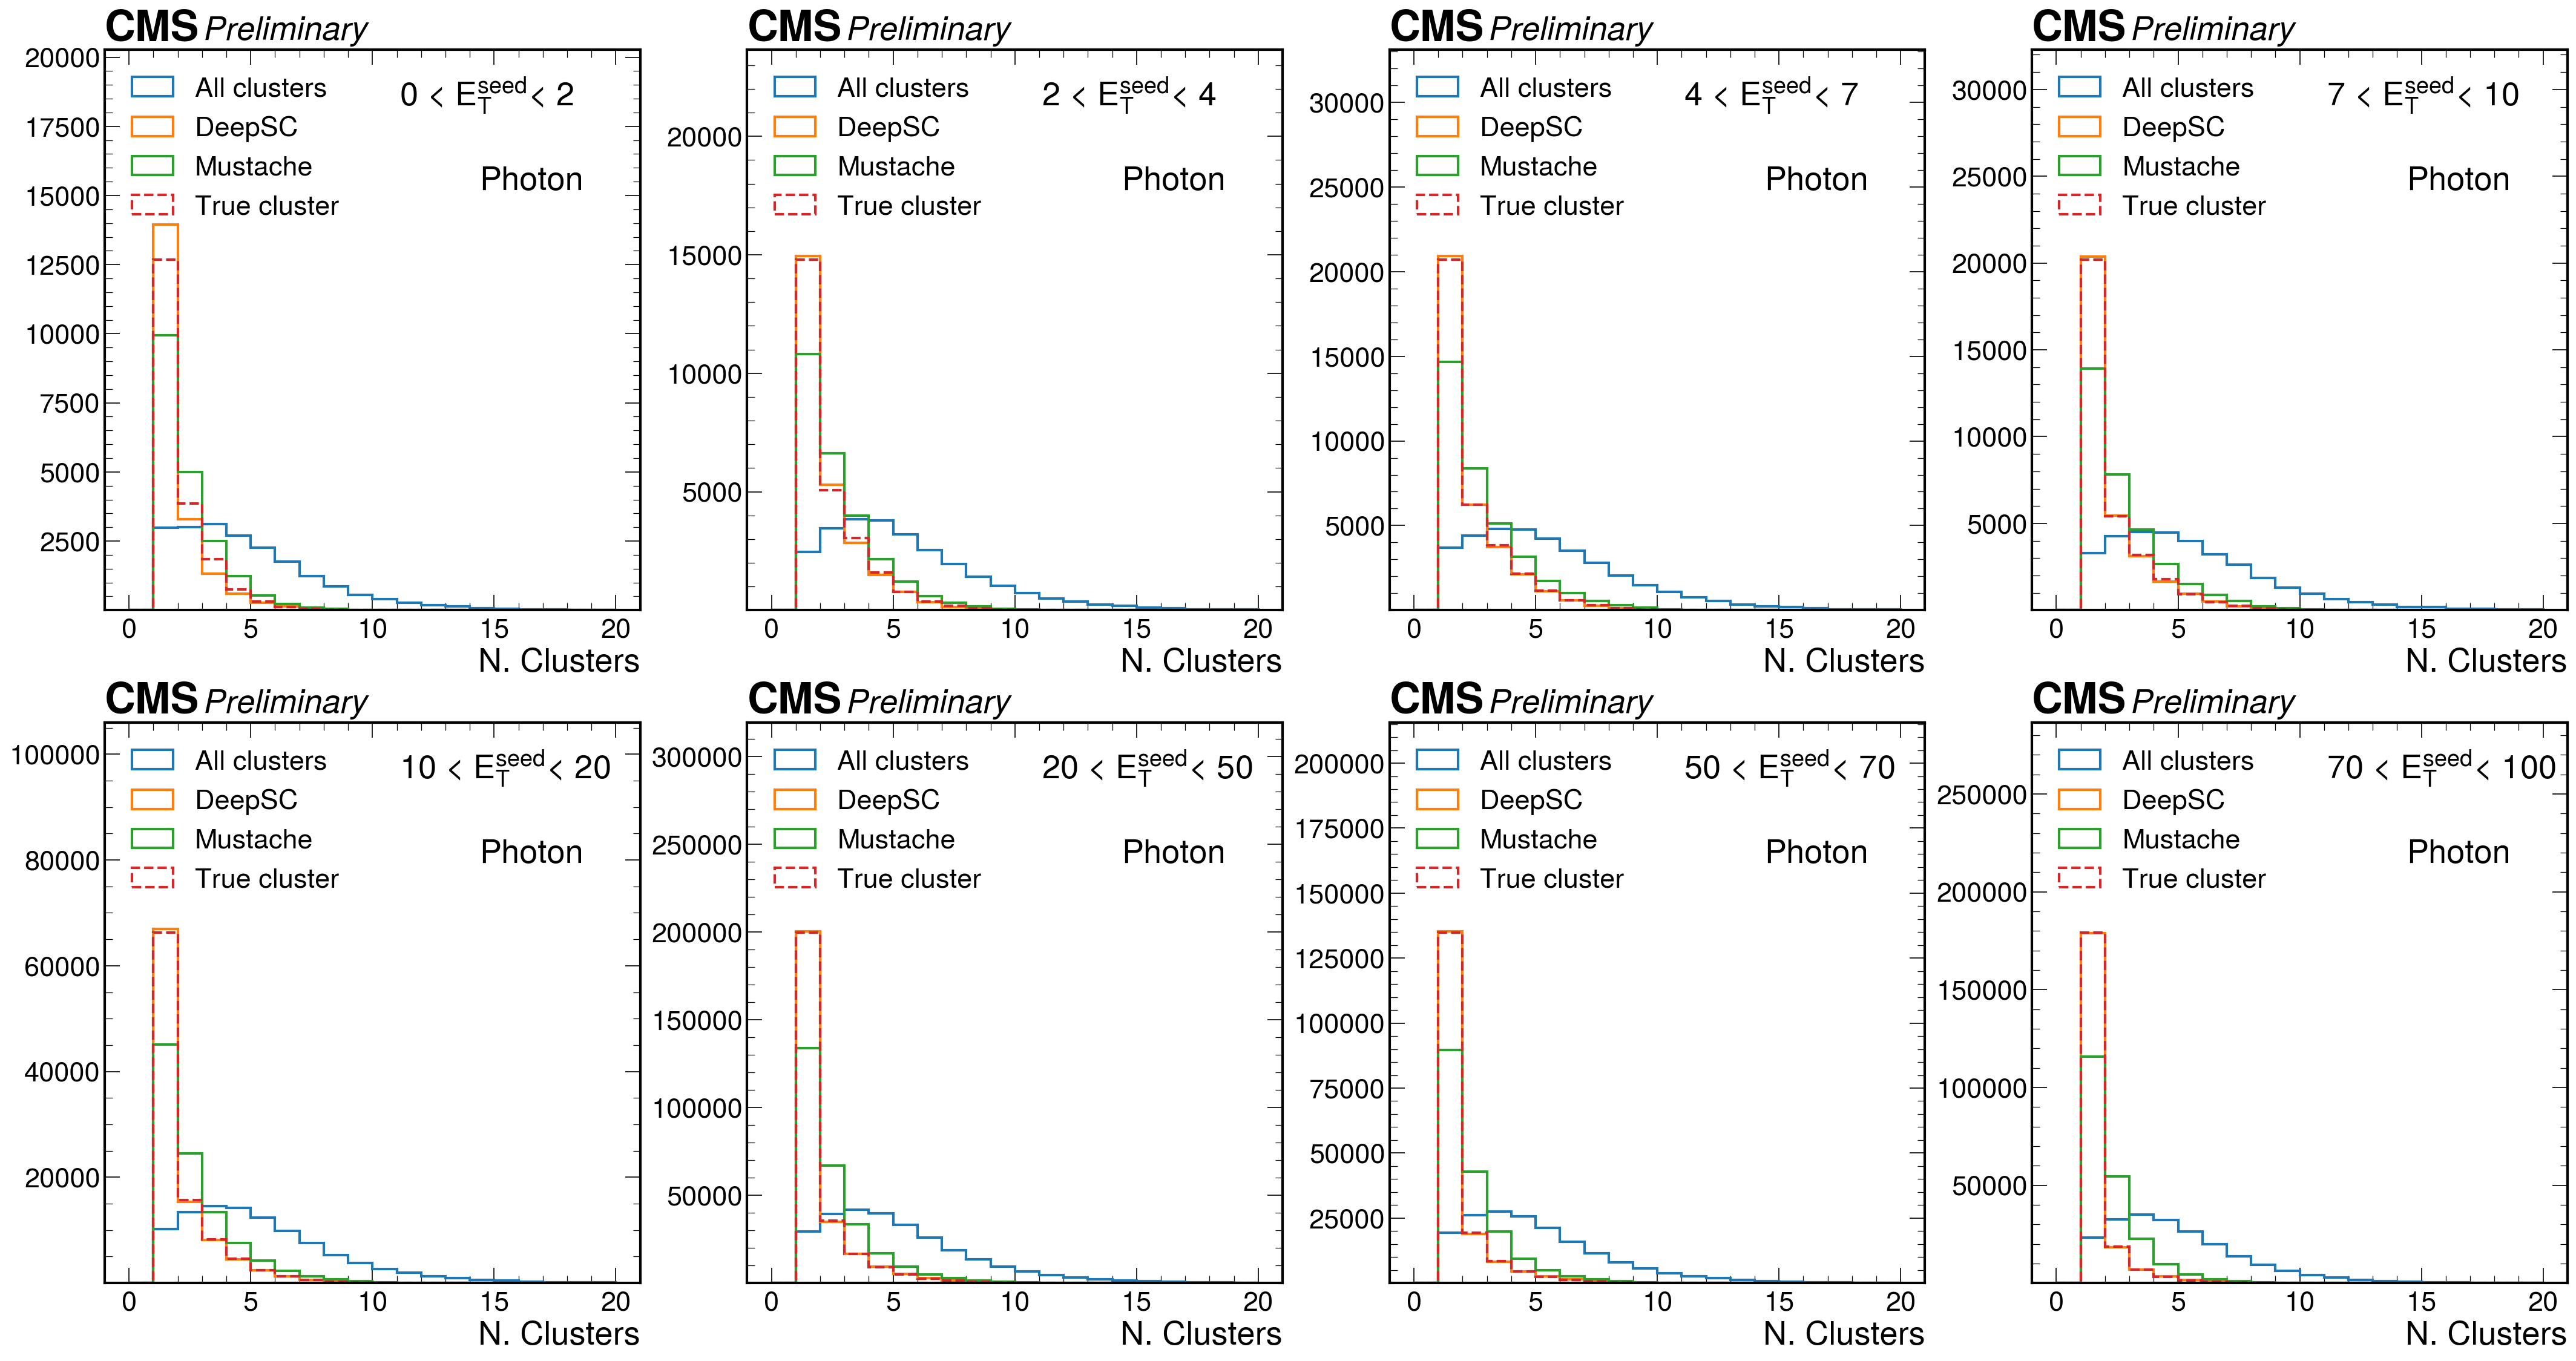

In [10]:
for df, flavour in zip([df_ele,df_gamma],["Electron","Photon"]):

    fig, ax = plt.subplots(2,4, figsize=(35,18),dpi=150)

    xrange = (0,20)
    bins= 20

    ets = [ [(0,2),(2,4),(4,7),(7,10)],[(10,20),(20,50),(50,70),(70,100)]]

    for j,etss in enumerate(ets): 
        for i, (e1,e2) in enumerate(etss): 
            dfx = df[(df.et>=e1) & (df.et<e2)]

            ax[j,i].hist(dfx.ncls,bins=bins, range=xrange, histtype='step', linewidth=2, label='All clusters')
            ax[j,i].hist(dfx.ncls_sel,bins=bins, range=xrange, histtype='step', linewidth=2, label='DeepSC')
            ax[j,i].hist(dfx.ncls_sel_must,bins=bins, range=xrange, histtype='step', linewidth=2, label='Mustache')
            A = ax[j,i].hist(dfx.ncls_true,bins=bins, range=xrange, histtype='step', linewidth=2, linestyle='dashed', label='True cluster')
            maxY = np.max(A[0])
            ax[j,i].legend(loc="upper left")
#             ax[j,i].set_yscale('log')
            ax[j,i].set_ylim(1, 1.6 * maxY)
            ax[j,i].set_xlabel("N. Clusters")
            ax[j,i].text(0.55,0.9,  str(e1) + ' < $E_T^{seed}$< ' + str(e2), transform = ax[j,i].transAxes)  
            ax[j,i].text(0.7, 0.75, flavour, transform=ax[j,i].transAxes)

            hep.cms.text("Preliminary ",loc=0, ax=ax[j,i])


# Resolution

In [11]:
def get_CI(histo, CL):
    Y, X = histo
    maxBin = np.argmax(Y)
    Xmax = (X[maxBin] + X[maxBin+1])/2
    # now we have to compute the simmetric interval
    Xr, Xl = 0, 0
    tot = np.sum(Y)
    thr = tot* CL/2
#     print(tot, thr)
    xi = maxBin+1
    Nu = Y[maxBin]/2
    Nd = Nu
    while(xi < len(X)):
        Nu += Y[xi]
        if Nu > thr:
            Xr = (X[xi] + X[xi+1])/2
            break
        else:
            xi+=1
            
    xi = maxBin-1
    while(xi > 0):
        Nd += Y[xi]
        if Nd > thr:
            Xl = (X[xi] + X[xi+1])/2
            break
        else:
            xi-=1
    
    return Xmax, Xr, Xl
    
def get_sigma_eff(df):
    A = (df.quantile(0.84) - df.quantile(0.16)) /2
    B = (df.quantile(0.025) - df.quantile(0.975)) /2
    return A,B

    

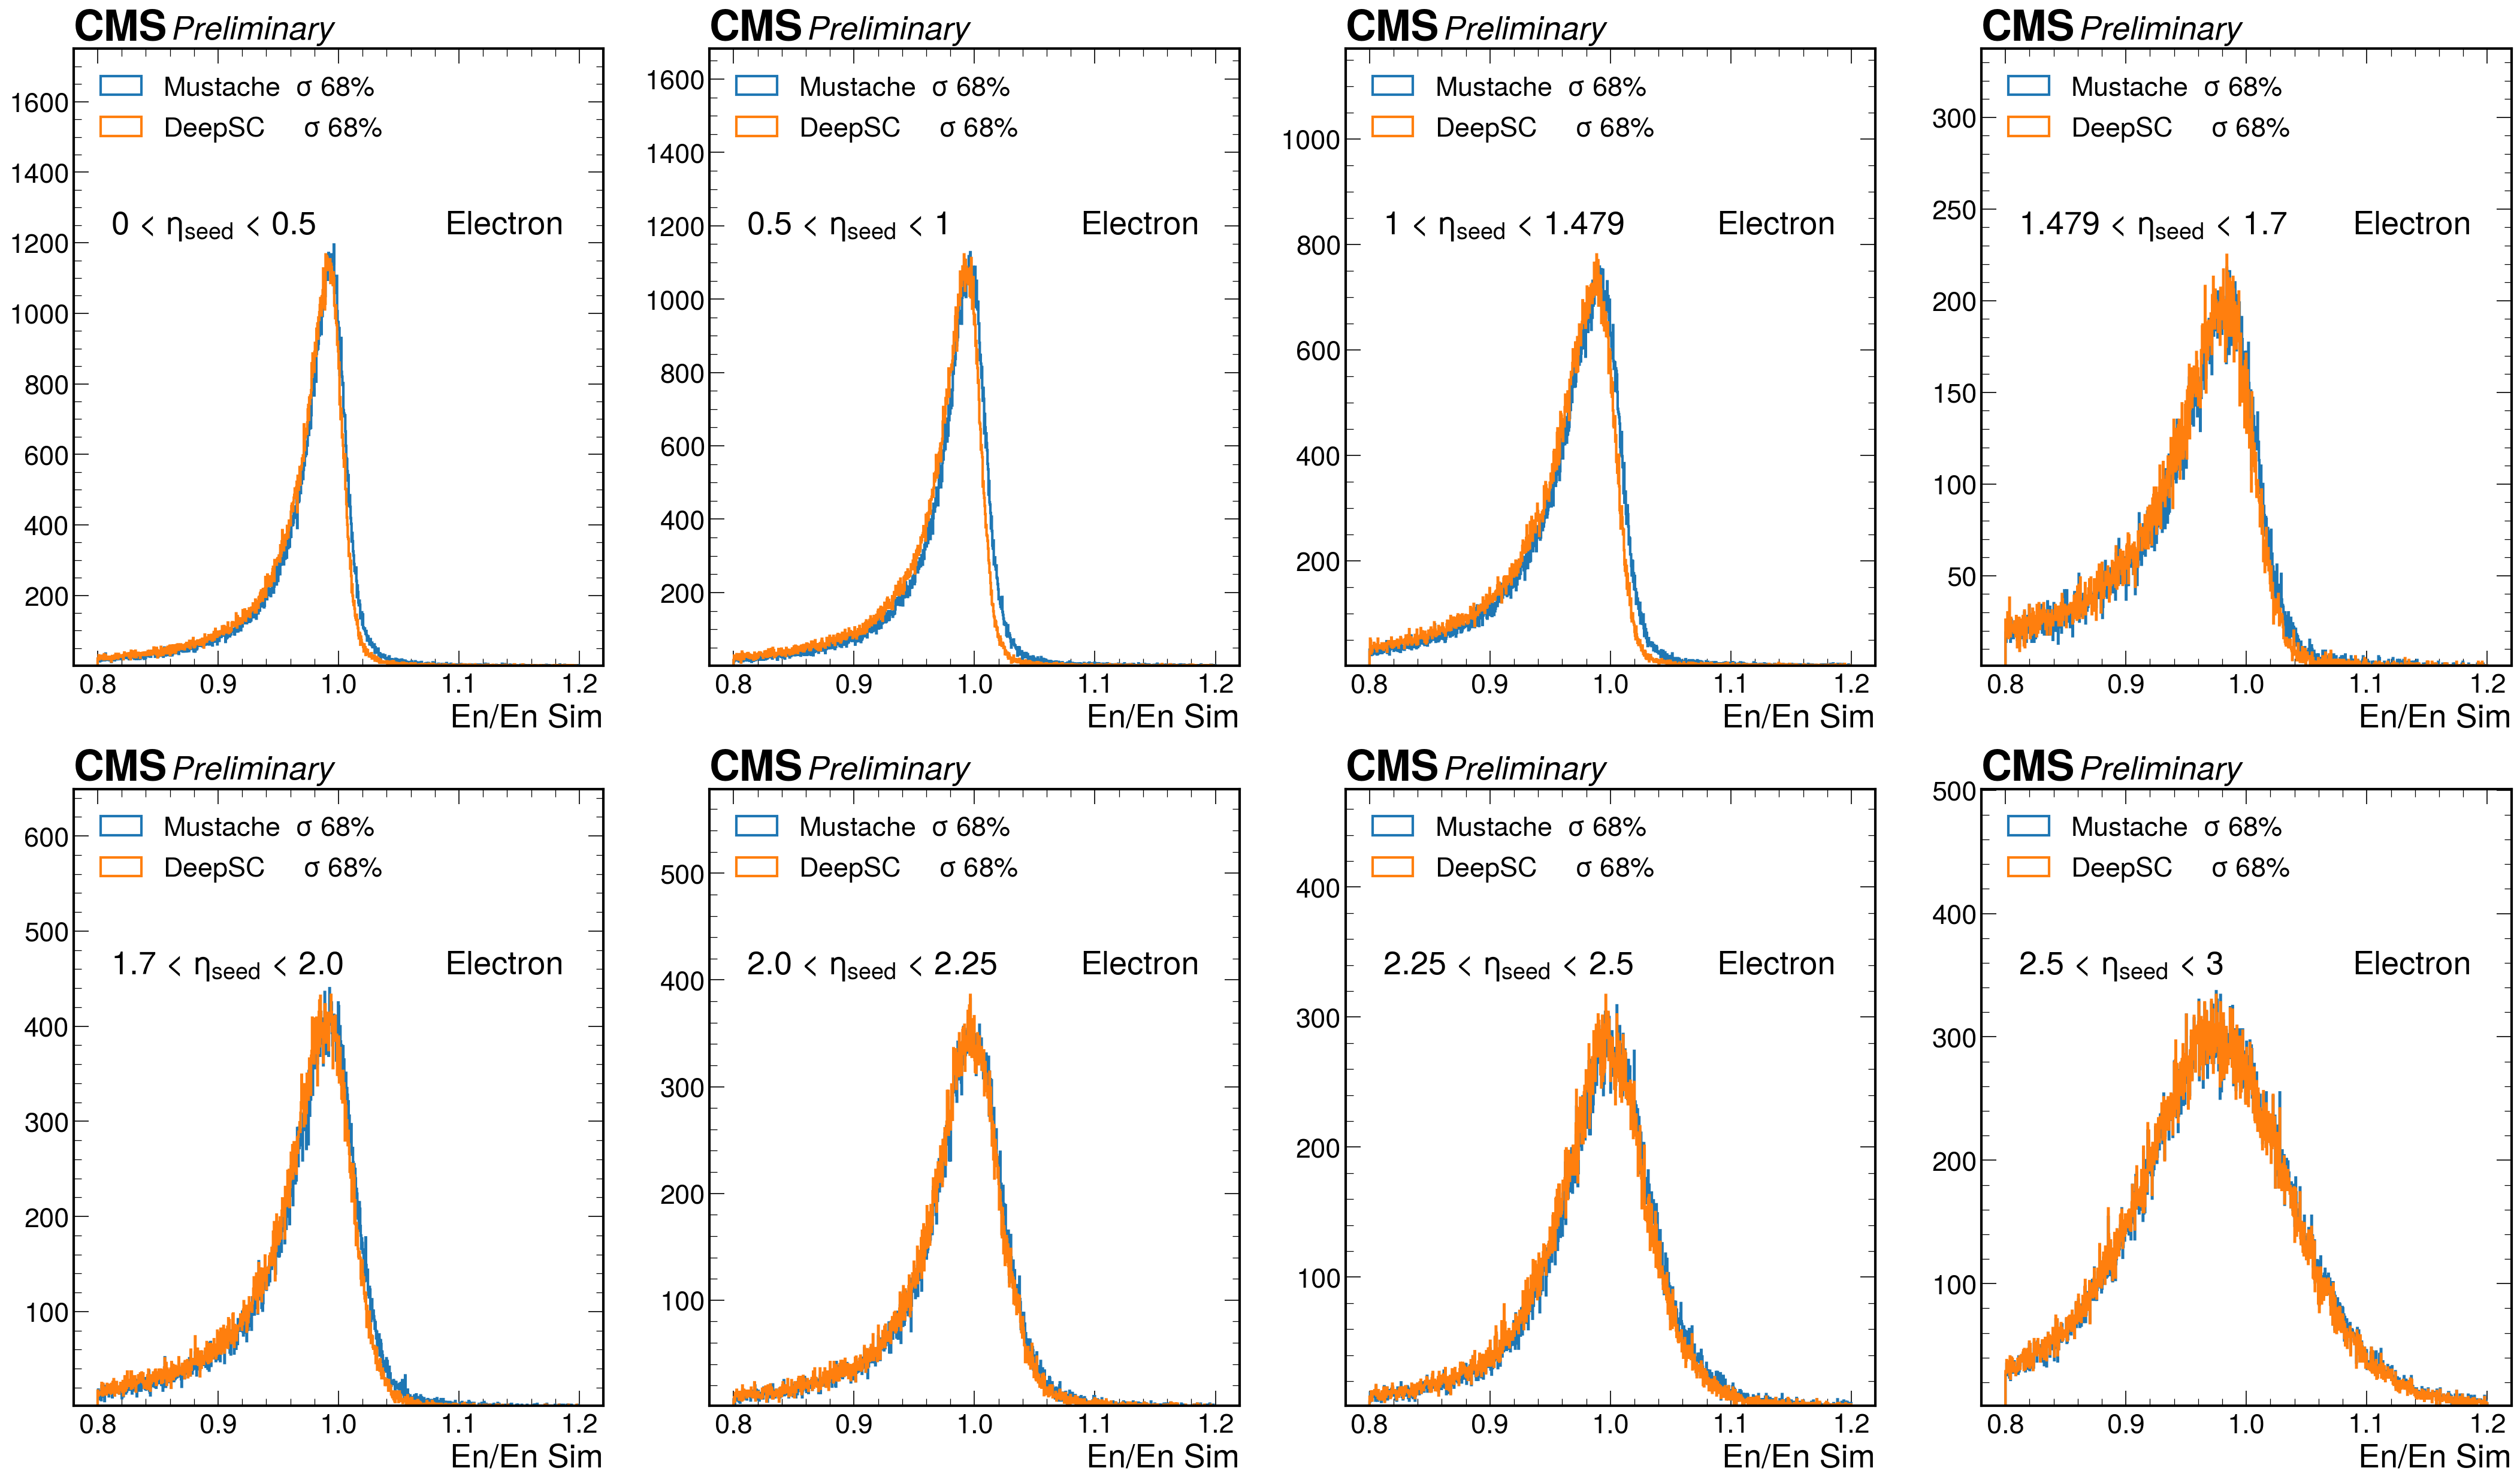

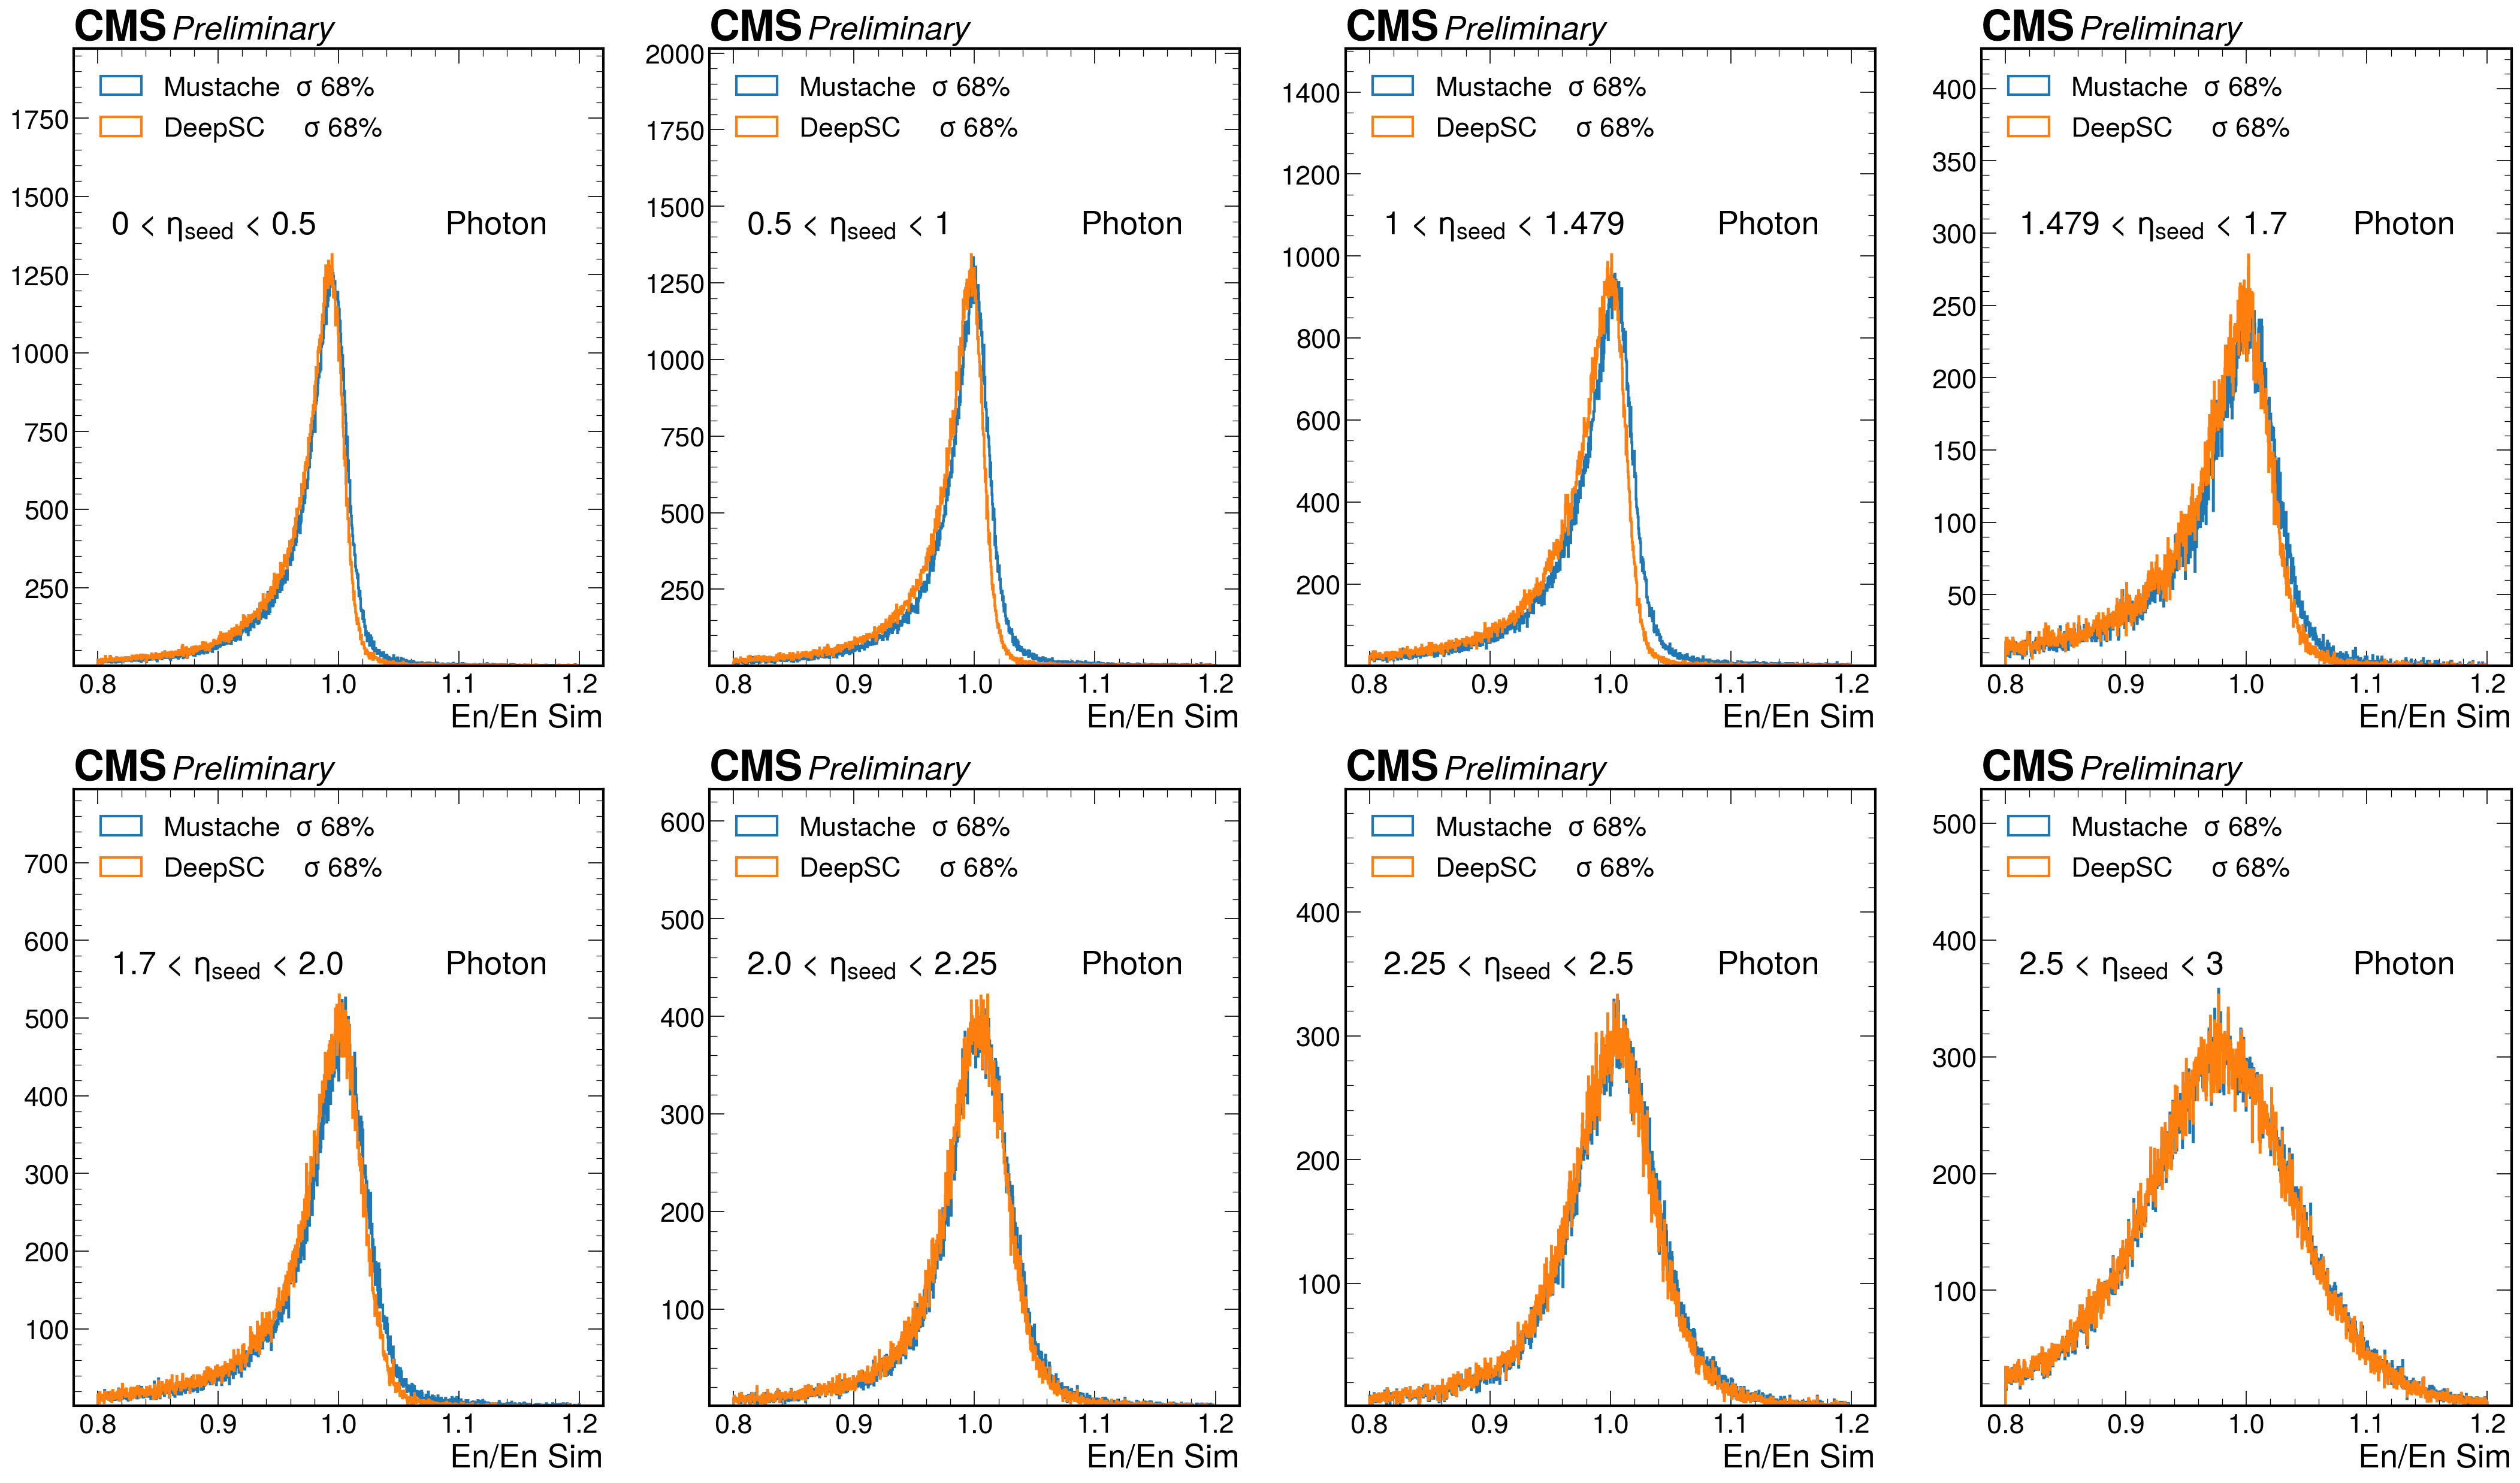

In [15]:
for df, flavour in zip([df_ele,df_gamma],["Electron","Photon"]):

    fig, ax = plt.subplots(2,4, figsize=(35,20),dpi=150)

    xrange = (0.8, 1.2)
    bins= 1000
    CL = 0.4


    r = [0, 0.5,1, 1.479, 1.7, 2.0, 2.25, 2.5, 3]
    s = [[], []]
    for i in range(len(r)-1):
        line = i //4 
        s[line].append((r[i],r[i+1]))

    for j,ss in enumerate(s): 
        for i, (e1,e2) in enumerate(ss): 
            dfx = df[(abs(df.seed_eta)>=e1) & (abs(df.seed_eta)<e2)]

            width, width_2 = get_sigma_eff(dfx.En_ovEtrue_sim_good)
            width_must, width_2_must = get_sigma_eff(dfx.En_ovEtrue_sim_good_mustache)
    #         rms_regr = dfx.En_ovEtrue_gen_corr.std()

            ax[j,i].hist(dfx.En_ovEtrue_sim_good_mustache,bins=bins, range=xrange,histtype='step', linewidth=2, label='Mustache  $\sigma$ 68%'.format(width_must, CL))
            A= ax[j,i].hist(dfx.En_ovEtrue_sim_good,bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC     $\sigma$ 68%'.format(width, CL))
    #         ax[j,i].hist(dfx.En_ovEtrue_gen_corr,bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC +regre    RMS: {:.4f}'.format(rms_regr))
            maxY = np.max(A[0])
            ax[j,i].legend(loc="upper left")
    #         ax[j,i].set_yscale('log')
            ax[j,i].set_ylim(1, 1.5 * maxY)
            ax[j,i].set_xlabel("En/En Sim")
            ax[j,i].text(0.07,0.7,  str(e1) + ' < $\eta_{seed}$ < ' + str(e2), transform = ax[j,i].transAxes)  
            ax[j,i].text(0.7, 0.7, flavour, transform=ax[j,i].transAxes)

            hep.cms.text("Preliminary ",loc=0, ax=ax[j,i])


In [17]:
def bin_analysis(col):
    def f(df):
        m = df[col].mode().values[0]
        A = (df[col].quantile(0.84) - df[col].quantile(0.16))/2
        B = (df[col].quantile(0.025) - df[col].quantile(0.975))/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B
        })
    return f

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

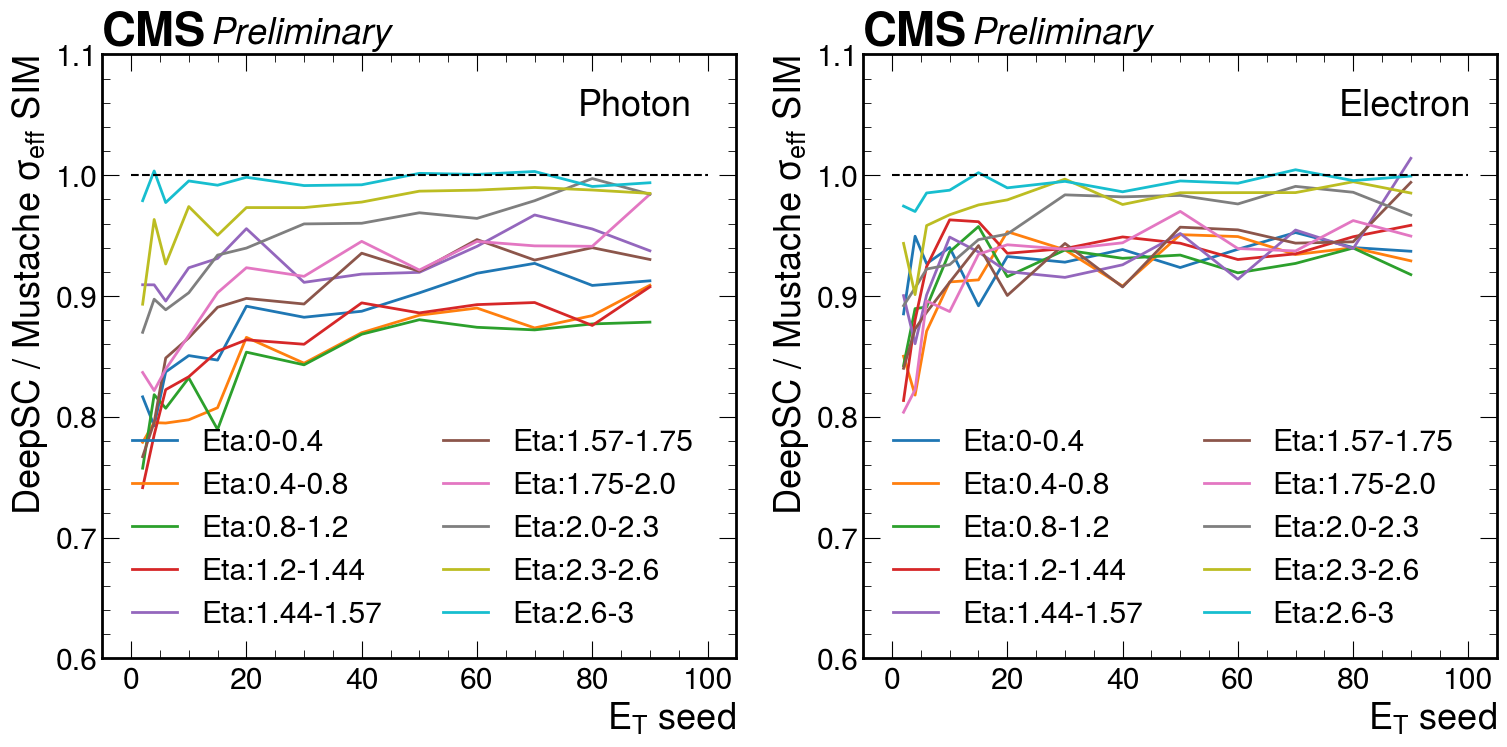

In [18]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(18,8),dpi=100, )

df = df_gamma
flavour = "Photon"
ets = [2, 4,6, 10,15,20,30,40,50,60,70,80,90,100]
etas = [0, 0.4,0.8, 1.2,1.44, 1.57, 1.75,2.,2.3,2.6,3]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)


# gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
# axs = gs.subplots(sharex=True)

for ieta, eta in enumerate(etas[:-1]):
    ax.plot(ets[:-1], res[res.eta_bin == ieta].w68/res_must[res_must.eta_bin == ieta].w68, label="Eta:{}-{}".format(etas[ieta], etas[ieta+1]), linewidth=2)
ax.set_ylim(0.6, 1.1)
ax.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ax.legend(ncol=2)
ax.set_xlabel("$E_T$ seed")
ax.plot([0,100],[1,1], linestyle="dashed", color="black")

ax.text(0.75, 0.9, flavour, transform=ax.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ax)



df = df_ele
flavour = "Electron"

ets = [2, 4,6,10,15,20,30,40,50,60,70,80,90,100]
etas =  [0, 0.4,0.8, 1.2,1.44, 1.57, 1.75,2.,2.3,2.6,3]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

for ieta, eta in enumerate(etas[:-1]):
    ay.plot(ets[:-1], res[res.eta_bin == ieta].w68/res_must[res_must.eta_bin == ieta].w68, label="Eta:{}-{}".format(etas[ieta], etas[ieta+1]), linewidth=2)
ay.set_ylim(0.6, 1.1)
ay.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ay.legend(ncol=2)
ay.set_xlabel("$E_T$ seed")
ay.plot([0,100],[1,1], linestyle="dashed", color="black")

ay.text(0.75, 0.9, flavour, transform=ay.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ay)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

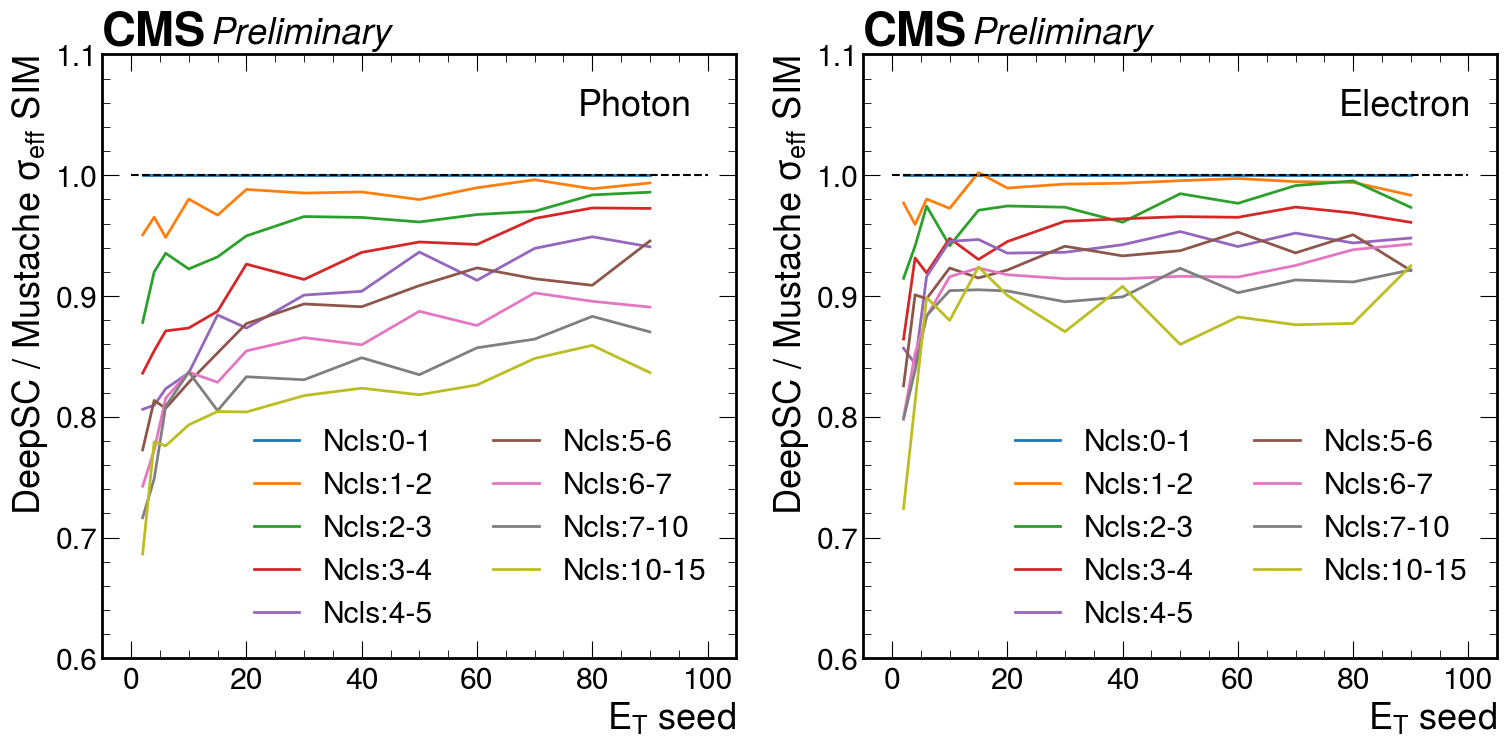

In [19]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(18,8),dpi=100, )

df = df_gamma
flavour ="Photon"
ets = [2,4,6,10,15,20,30,40,50,60,70,80,90,100]
ncls = [0,1,2,3,4,5,6,7,10,15]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["ncls_bin"] = pd.cut(df.ncls, ncls, labels=list(range(len(ncls)-1)))


res = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)


# gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
# axs = gs.subplots(sharex=True)

for ieta, eta in enumerate(ncls[:-1]):
    ax.plot(ets[:-1], res[res.ncls_bin == ieta].w68/res_must[res_must.ncls_bin == ieta].w68, label="Ncls:{}-{}".format(ncls[ieta], ncls[ieta+1]), linewidth=2)
ax.set_ylim(0.6, 1.1)
ax.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ax.legend(ncol=2)
ax.set_xlabel("$E_T$ seed")
ax.plot([0,100],[1,1], linestyle="dashed", color="black")

ax.text(0.75, 0.9, flavour, transform=ax.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ax)



df = df_ele
flavour = "Electron"

ets = [2,4,6,10,15,20,30,40,50,60,70,80,90,100]
ncls = [0,1,2,3,4,5,6,7,10,15]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["ncls_bin"] = pd.cut(df.ncls, ncls, labels=list(range(len(ncls)-1)))


res = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

for ieta, eta in enumerate(ncls[:-1]):
    ay.plot(ets[:-1], res[res.ncls_bin == ieta].w68/res_must[res_must.ncls_bin == ieta].w68, label="Ncls:{}-{}".format(ncls[ieta], ncls[ieta+1]), linewidth=2)
ay.set_ylim(0.6, 1.1)
ay.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ay.legend(ncol=2)
ay.set_xlabel("$E_T$ seed")
ay.plot([0,100],[1,1], linestyle="dashed", color="black")

ay.text(0.75, 0.9, flavour, transform=ay.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ay)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

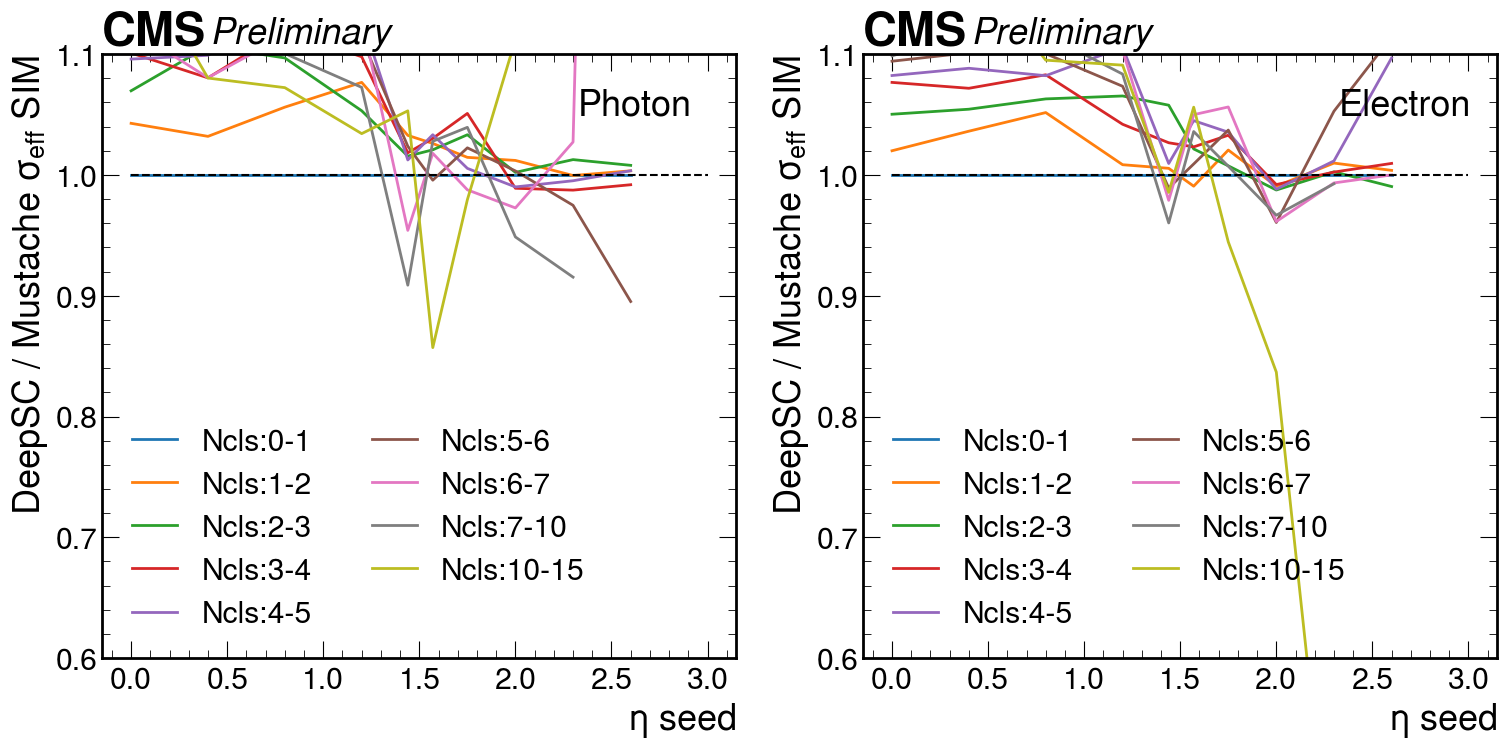

In [28]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(18,8),dpi=100, )

df = df_gamma
flavour ="Photon"
etas =  [0, 0.4,0.8, 1.2,1.44, 1.57, 1.75,2.,2.3,2.6,3]
ncls = [0,1,2,3,4,5,6,7,10,15]
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))
df["ncls_bin"] = pd.cut(df.ncls, ncls, labels=list(range(len(ncls)-1)))


res = df.groupby(["eta_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["eta_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)


# gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
# axs = gs.subplots(sharex=True)

for ieta, eta in enumerate(ncls[:-1]):
    ax.plot(etas[:-1], res[res.ncls_bin == ieta].w68/res_must[res_must.ncls_bin == ieta].w68, label="Ncls:{}-{}".format(ncls[ieta], ncls[ieta+1]), linewidth=2)
ax.set_ylim(0.6, 1.1)
ax.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ax.legend(ncol=2)
ax.set_xlabel("$\eta$ seed")
ax.plot([0,3],[1,1], linestyle="dashed", color="black")

ax.text(0.75, 0.9, flavour, transform=ax.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ax)



df = df_ele
flavour = "Electron"

etas =  [0, 0.4,0.8, 1.2,1.44, 1.57, 1.75,2.,2.3,2.6,3]
ncls = [0,1,2,3,4,5,6,7,10,15]
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))
df["ncls_bin"] = pd.cut(df.ncls, ncls, labels=list(range(len(ncls)-1)))


res = df.groupby(["eta_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["eta_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

for ieta, eta in enumerate(ncls[:-1]):
    ay.plot(etas[:-1], res[res.ncls_bin == ieta].w68/res_must[res_must.ncls_bin == ieta].w68, label="Ncls:{}-{}".format(ncls[ieta], ncls[ieta+1]), linewidth=2)
ay.set_ylim(0.6, 1.1)
ay.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ay.legend(ncol=2)
ay.set_xlabel("$\eta$ seed")
ay.plot([0,3],[1,1], linestyle="dashed", color="black")

ay.text(0.75, 0.9, flavour, transform=ay.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ay)

In [23]:
df.columns

Index(['ncls', 'ncls_true', 'ncls_sel', 'ncls_sel_true', 'ncls_sel_must',
       'ncls_sel_must_true', 'Et_tot', 'En_tot', 'Et_true', 'Et_sel',
       'Et_sel_true', 'En_true', 'En_true_sim', 'En_true_sim_good',
       'En_true_gen', 'En_sel', 'En_sel_true', 'En_sel_corr', 'Et_ovEtrue',
       'En_ovEtrue', 'En_ovEtrue_sim', 'En_ovEtrue_sim_good',
       'EnTrue_ovEtrue_sim', 'EnTrue_ovEtrue_sim_good', 'Et_sel_must',
       'En_sel_must', 'Et_sel_must_true', 'En_sel_must_true',
       'Et_ovEtrue_mustache', 'En_ovEtrue_mustache', 'En_ovEtrue_sim_mustache',
       'En_ovEtrue_sim_good_mustache', 'en_regr_factor', 'En_ovEtrue_gen',
       'En_ovEtrue_gen_mustache', 'En_ovEtrue_gen_corr', 'flavour', 'seed_eta',
       'seed_phi', 'seed_ieta', 'seed_iphi', 'seed_iz', 'en_seed', 'et_seed',
       'en_seed_calib', 'et_seed_calib', 'seed_r9', 'seed_swissCross',
       'seed_nxtals', 'max_en_cluster', 'max_et_cluster', 'max_deta_cluster',
       'max_dphi_cluster', 'max_den_cluster', 'max_det_

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

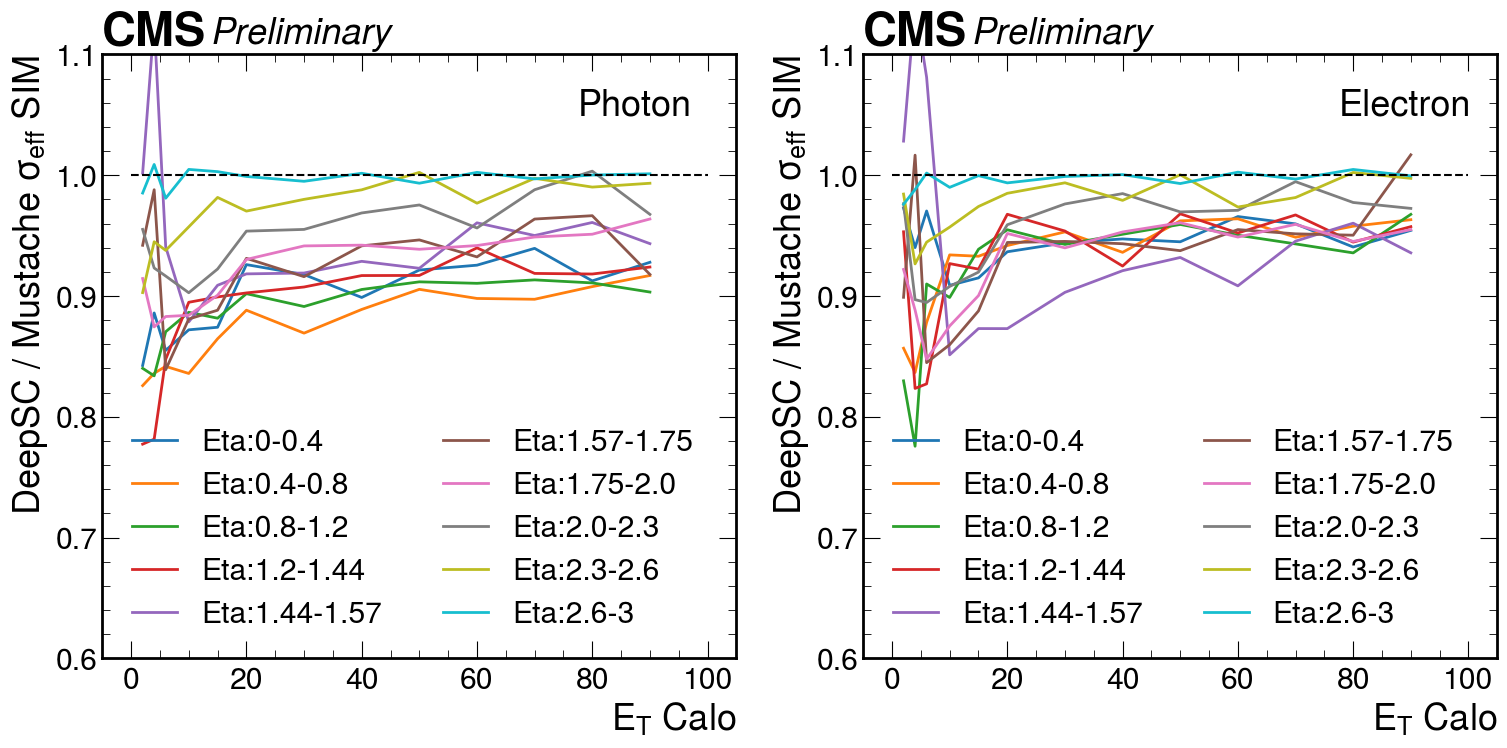

In [27]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(18,8),dpi=100, )

df = df_gamma
flavour = "Photon"
ets = [2, 4,6, 10,15,20,30,40,50,60,70,80,90,100]
etas = [0, 0.4,0.8, 1.2,1.44, 1.57, 1.75,2.,2.3,2.6,3]
df["et_bin"] = pd.cut(df.En_true_sim_good / np.cosh(df.sim_true_eta) , ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))



res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)


# gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
# axs = gs.subplots(sharex=True)

for ieta, eta in enumerate(etas[:-1]):
    ax.plot(ets[:-1], res[res.eta_bin == ieta].w68/res_must[res_must.eta_bin == ieta].w68, label="Eta:{}-{}".format(etas[ieta], etas[ieta+1]), linewidth=2)
ax.set_ylim(0.6, 1.1)
ax.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ax.legend(ncol=2)
ax.set_xlabel("$E_T$ Calo")
ax.plot([0,100],[1,1], linestyle="dashed", color="black")

ax.text(0.75, 0.9, flavour, transform=ax.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ax)



df = df_ele
flavour = "Electron"

ets = [2, 4,6,10,15,20,30,40,50,60,70,80,90,100]
etas =  [0, 0.4,0.8, 1.2,1.44, 1.57, 1.75,2.,2.3,2.6,3]
df["et_bin"] = pd.cut(df.En_true_sim_good / np.cosh(df.sim_true_eta) , ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

for ieta, eta in enumerate(etas[:-1]):
    ay.plot(ets[:-1], res[res.eta_bin == ieta].w68/res_must[res_must.eta_bin == ieta].w68, label="Eta:{}-{}".format(etas[ieta], etas[ieta+1]), linewidth=2)
ay.set_ylim(0.6, 1.1)
ay.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ay.legend(ncol=2)
ay.set_xlabel("$E_T$ Calo")
ay.plot([0,100],[1,1], linestyle="dashed", color="black")

ay.text(0.75, 0.9, flavour, transform=ay.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ay)